<a href="https://colab.research.google.com/github/casjunior93/projeto-integrador-iv/blob/master/Etl_e_cria%C3%A7%C3%A3o_de_Modelos_com_Arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas fundamentais

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import scipy.stats as stats
import urllib.request, json 
from pandas.io.json import json_normalize
import pickle

#Scikit-Learn
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#Configura o pandas para não exibir resultados em notação científica
pd.options.display.float_format = '{:.2f}'.format

#Semente aleatória do Numpy
np.random.seed(42)

#Data local
import locale
# Colab não suporta
#locale.setlocale(locale.LC_ALL, 'pt_BR.utf8')

# URL base da api de dados

In [2]:
url_base = 'https://univesp-analytics.vercel.app/api/get'

# Lendo Json com Pandas

In [3]:
%%time
pagina = 1
limite = 10000
fim_iteracao_api = False
df_dados_api_original = pd.DataFrame([])

print(f'Início das requisições')
while fim_iteracao_api == False:
  with urllib.request.urlopen(url_base + '?page=' + str(pagina) + '&limite=' + str(limite)) as url:
    data = json.loads(url.read().decode())
    df = pd.DataFrame(json_normalize(data))
    print('.', end='')
    if len(data) == 0:
      print('')
      print(f'Fim. Total de {pagina - 1} páginas e {df_dados_api_original.shape[0]} registros.')
      fim_iteracao_api = True
    else:
      if pagina % 100 == 0:
        print(f'Fim leitura página {pagina}')
      pagina += 1
      df_dados_api_original = pd.concat([df_dados_api_original, df], ignore_index = True)

Início das requisições
..........
Fim. Total de 9 páginas e 86202 registros.
CPU times: user 1.08 s, sys: 76.7 ms, total: 1.16 s
Wall time: 20.2 s


In [4]:
%%time
''' with urllib.request.urlopen(url_base + '?page=' + str(pagina) + '&limite=' + str(limite)) as url:
    data = json.loads(url.read().decode())
    df_dados_api_original = pd.DataFrame(json_normalize(data)) '''

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


" with urllib.request.urlopen(url_base + '?page=' + str(pagina) + '&limite=' + str(limite)) as url:\n    data = json.loads(url.read().decode())\n    df_dados_api_original = pd.DataFrame(json_normalize(data)) "

Cópia dos dados da api

In [5]:
df_dados_api = df_dados_api_original.copy()

Dimensão dos dados - Linhas, colunas

In [6]:
df_dados_api.shape

(86202, 9)

# Visualizando dados originais

Mudando ordenação dos dados

In [7]:
df_dados_api.sort_index(ascending=False, inplace=True, ignore_index=True)

Cinco primeiros registros do dataframe - Em ordem da disposição na API

In [8]:
df_dados_api.head()

,_id,temp_ar,umid_ar,type,local,time.time_js,time.data,time.hora,teste
0,63fea0720dd58484fc266c80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.00
1,63ffdbb91a4eb0dfdd6a11a7,2,3,teste,NaN,2023-03-01T23:11:53.036Z,01/03/2023,20:11:53,NaN
2,63ffdbde1a4eb0dfdd6a11a8,10,10,teste,NaN,2023-03-01T23:12:30.063Z,01/03/2023,20:12:30,NaN
3,63ffdea6722bef68acc5bb72,333,333,teste,NaN,2023-03-01T23:24:21.438Z,01/03/2023,23:24:21,NaN
4,63ffed2b38c8784e07b788f2,15,15,teste,NaN,01/03/2023 21:26:19,01/03/2023,21:26:19,NaN


Cinco últimos registros do dataframe

In [9]:
df_dados_api.tail()

,_id,temp_ar,umid_ar,type,local,time.time_js,time.data,time.hora,teste
86197,645cd7cfadefe4cbd6fc7b29,25.60,56.90,teste,comAr,"11/05/2023, 08:55:59","11/05/2023,",08:55:59,NaN
86198,645cd8c4adefe4cbd6fc7b2a,20.90,71.90,teste,semAr,"11/05/2023, 09:00:04","11/05/2023,",09:00:04,NaN
86199,645cd8fdadefe4cbd6fc7b2b,25.20,58.10,teste,comAr,"11/05/2023, 09:01:01","11/05/2023,",09:01:01,NaN
86200,645cd9f2adefe4cbd6fc7b2c,20.90,72.90,teste,semAr,"11/05/2023, 09:05:06","11/05/2023,",09:05:06,NaN
86201,645cda2cadefe4cbd6fc7b2d,25.50,57.30,teste,comAr,"11/05/2023, 09:06:04","11/05/2023,",09:06:04,NaN


Verificando dados nulos

In [10]:
df_dados_api.isnull().sum()

_id                 0
temp_ar             3
umid_ar             3
type                1
local           55412
time.time_js        1
time.data           1
time.hora           1
teste           86201
dtype: int64

Excluindo colunas desnecessárias

In [11]:
del df_dados_api['teste']
del df_dados_api['_id']
del df_dados_api['type']
del df_dados_api['time.time_js']
df_dados_api.head()

,temp_ar,umid_ar,local,time.data,time.hora
0,NaN,NaN,NaN,NaN,NaN
1,2,3,NaN,01/03/2023,20:11:53
2,10,10,NaN,01/03/2023,20:12:30
3,333,333,NaN,01/03/2023,23:24:21
4,15,15,NaN,01/03/2023,21:26:19


Tratando nova coluna local

In [12]:
df_dados_api.local.value_counts()

semAr    23944
comAr     6842
API          2
teste        1
123          1
Name: local, dtype: int64

In [13]:
values = {"local": "comAr"}
df_dados_api.fillna(value=values, inplace=True)

In [14]:
df_dados_api.local.value_counts()

comAr    62254
semAr    23944
API          2
teste        1
123          1
Name: local, dtype: int64

Limpeza de dados nulos

In [15]:
df_dados_api.dropna(inplace = True)
df_dados_api.isnull().sum()

temp_ar      0
umid_ar      0
local        0
time.data    0
time.hora    0
dtype: int64

Removendo dados duplicados

In [16]:
df_dados_api.shape

(86199, 5)

In [17]:
df_dados_api.drop_duplicates(inplace=True, ignore_index=True)
df_dados_api.shape

(86199, 5)

# Comportamento das variáveis

Tipo dos dados e convertendo strings para float

In [18]:
df_dados_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86199 entries, 0 to 86198
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   temp_ar    86199 non-null  object
 1   umid_ar    86199 non-null  object
 2   local      86199 non-null  object
 3   time.data  86199 non-null  object
 4   time.hora  86199 non-null  object
dtypes: object(5)
memory usage: 3.3+ MB


In [19]:
df_dados_api = df_dados_api.astype({'temp_ar':'float', 'umid_ar':'float'})
df_dados_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86199 entries, 0 to 86198
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   temp_ar    86199 non-null  float64
 1   umid_ar    86199 non-null  float64
 2   local      86199 non-null  object 
 3   time.data  86199 non-null  object 
 4   time.hora  86199 non-null  object 
dtypes: float64(2), object(3)
memory usage: 3.3+ MB


Análise descritiva dos dados

In [20]:
df_dados_api.describe()

,temp_ar,umid_ar
count,86199.00,86199.00
mean,25.56,59.71
std,2.57,8.28
min,2.00,3.00
25%,24.80,54.00
50%,25.90,58.00
75%,26.50,64.20
max,333.00,333.00


Opa, parece haver outliers.

Separando os conjuntos de dados do ambiente com ar condicionado e sem ar condicionado.

In [21]:
df_comAr = df_dados_api.loc[df_dados_api['local'] == 'comAr']
df_semAr = df_dados_api.loc[df_dados_api['local'] == 'semAr']

Verificando outliers

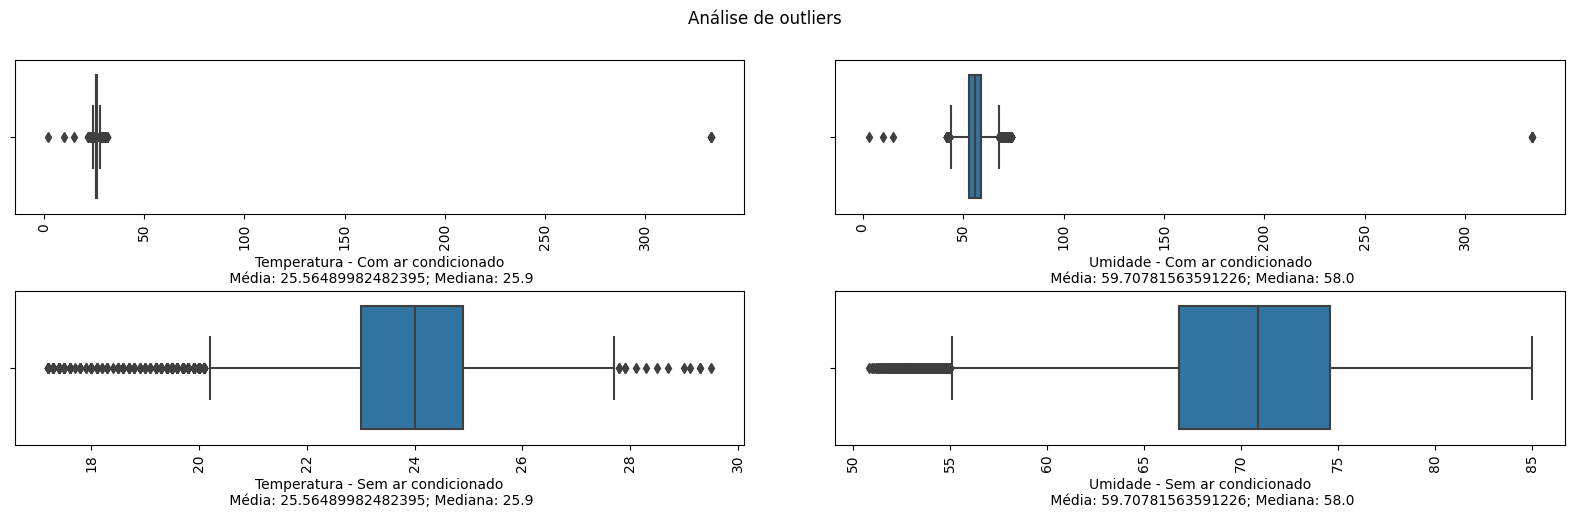

CPU times: user 403 ms, sys: 108 ms, total: 511 ms
Wall time: 432 ms


In [22]:
%%time
fig, axes = plt.subplots(2, 2, figsize = (20,5))
fig.subplots_adjust(hspace=0.5, wspace=0.125)
fig.suptitle('Análise de outliers')

#Temperatura Com ar condicionado - Boxplot
sns.boxplot(ax=axes[0,0],x=df_comAr['temp_ar'])
axes[0,0].tick_params(axis='x', rotation=90)
axes[0,0].set(xlabel='Temperatura - Com ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade Com ar condicionado - Boxplot
sns.boxplot(ax=axes[0,1],x=df_comAr['umid_ar'])
axes[0,1].tick_params(axis='x', rotation=90)
axes[0,1].set(xlabel='Umidade - Com ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

#Temperatura Com ar condicionado - Boxplot
sns.boxplot(ax=axes[1,0],x=df_semAr['temp_ar'])
axes[1,0].tick_params(axis='x', rotation=90)
axes[1,0].set(xlabel='Temperatura - Sem ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade Com ar condicionado - Boxplot
sns.boxplot(ax=axes[1,1],x=df_semAr['umid_ar'])
axes[1,1].tick_params(axis='x', rotation=90)
axes[1,1].set(xlabel='Umidade - Sem ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

plt.show();

Excluindo outliers superiores do conjunto com ar condicionado

In [23]:
def limites_outliers(coluna):
  Q1 = coluna.quantile(.25)
  Q3 = coluna.quantile(.75)
  IIQ = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IIQ
  limite_superior = Q3 + 1.5 * IIQ
  return limite_inferior, limite_superior

In [24]:
limite_inferior_temp_ar, limite_superior_temp_ar = limites_outliers(df_comAr['temp_ar'])
limite_inferior_umid_ar, limite_superior_umid_ar = limites_outliers(df_comAr['umid_ar'])

Visualizando registros considerados como outliers

In [25]:
selecao_temp_ar = (df_comAr['temp_ar'] > limite_superior_temp_ar) | (df_comAr['umid_ar'] > limite_superior_umid_ar)
temp_ar1 = df_comAr[selecao_temp_ar]
temp_ar1.describe()

,temp_ar,umid_ar
count,1986.00,1986.00
mean,28.23,54.82
std,13.79,15.31
min,21.90,43.00
25%,28.10,48.00
50%,28.20,51.00
75%,28.40,55.00
max,333.00,333.00


In [26]:
selecao_temp_ar2 = (temp_ar1['temp_ar'] < 333.0) | (temp_ar1['umid_ar'] < 333.0)
temp_ar2 = temp_ar1[selecao_temp_ar2]
temp_ar2.describe()

,temp_ar,umid_ar
count,1982.00,1982.00
mean,27.61,54.26
std,1.60,8.85
min,21.90,43.00
25%,28.10,48.00
50%,28.20,51.00
75%,28.40,55.00
max,31.20,74.00


Removendo dados com valor de temp_ar e umid_ar iguais à 333,0. Não vou remover valores menores que este porque são valores possíveis de acontecer.

In [27]:
selecao_temp_ar = (df_comAr['temp_ar'] <= 31.20) & (df_comAr['umid_ar'] <= 74)
df_comAr = df_comAr[selecao_temp_ar]

Revendo boxplots

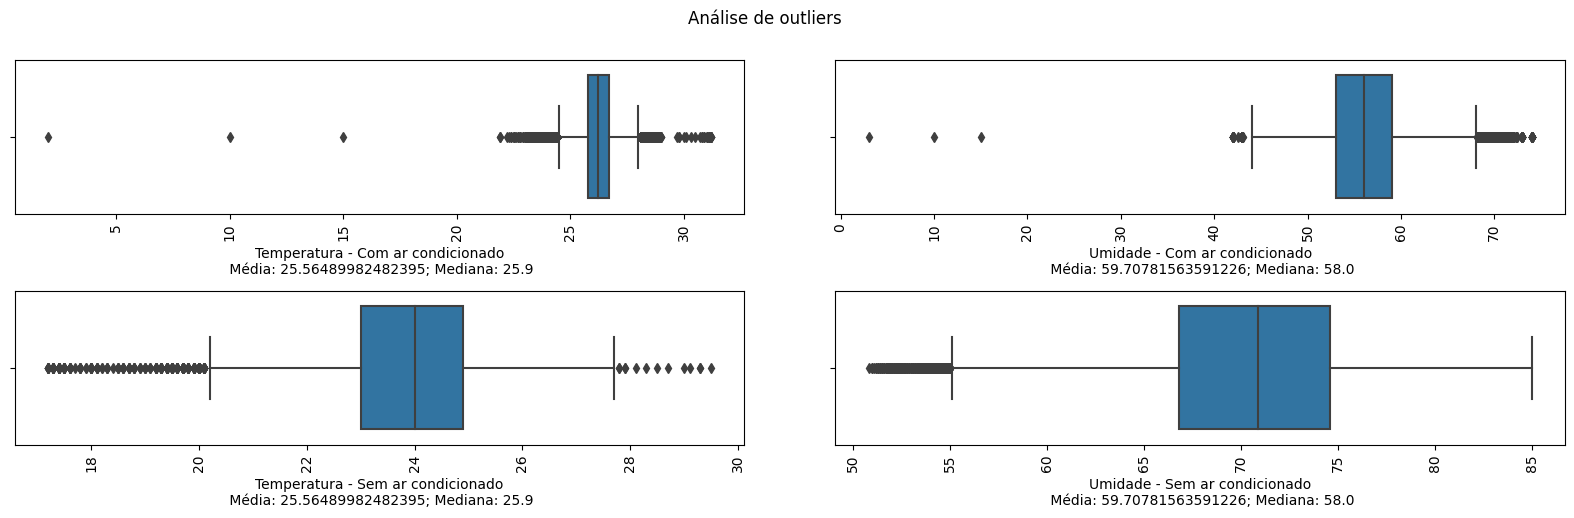

In [28]:
fig, axes = plt.subplots(2, 2, figsize = (20,5))
fig.subplots_adjust(hspace=0.5, wspace=0.125)
fig.suptitle('Análise de outliers')

#Temperatura Com ar condicionado - Boxplot
sns.boxplot(ax=axes[0,0],x=df_comAr['temp_ar'])
axes[0,0].tick_params(axis='x', rotation=90)
axes[0,0].set(xlabel='Temperatura - Com ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade Com ar condicionado - Boxplot
sns.boxplot(ax=axes[0,1],x=df_comAr['umid_ar'])
axes[0,1].tick_params(axis='x', rotation=90)
axes[0,1].set(xlabel='Umidade - Com ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

#Temperatura Com ar condicionado - Boxplot
sns.boxplot(ax=axes[1,0],x=df_semAr['temp_ar'])
axes[1,0].tick_params(axis='x', rotation=90)
axes[1,0].set(xlabel='Temperatura - Sem ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade Com ar condicionado - Boxplot
sns.boxplot(ax=axes[1,1],x=df_semAr['umid_ar'])
axes[1,1].tick_params(axis='x', rotation=90)
axes[1,1].set(xlabel='Umidade - Sem ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

plt.show();

Agora as curvas de densidade das variáveis

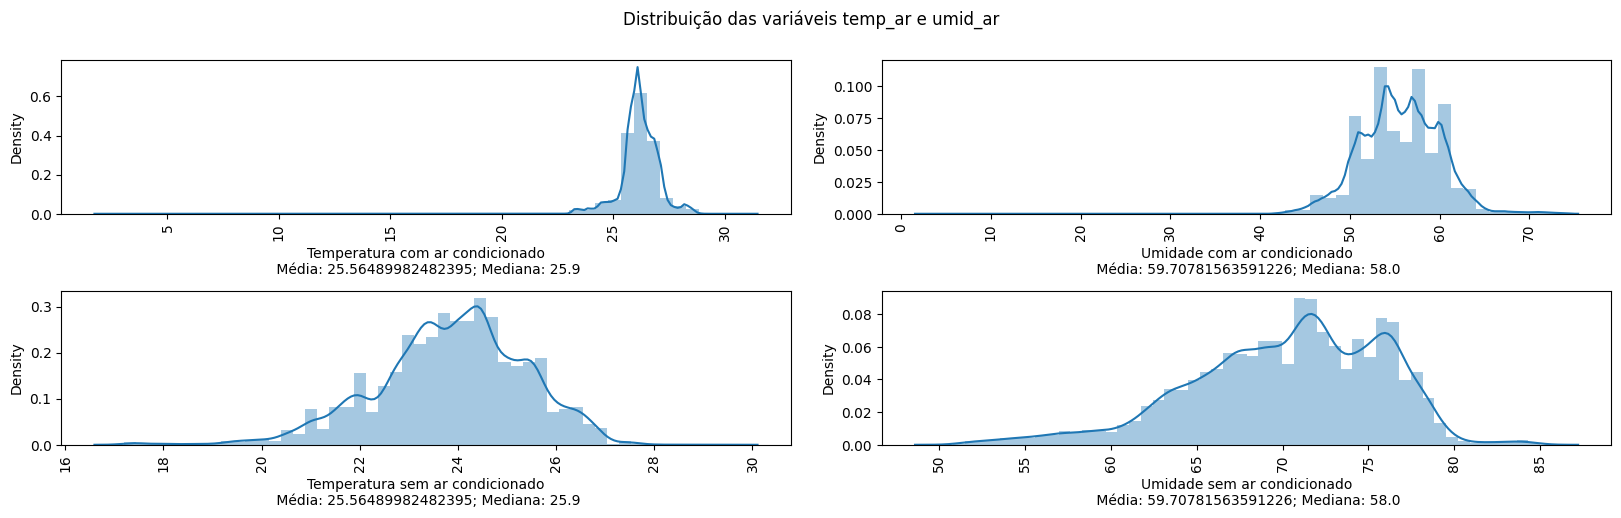

CPU times: user 1.63 s, sys: 577 ms, total: 2.21 s
Wall time: 1.7 s


In [29]:
%%time
fig, axes = plt.subplots(2, 2, figsize = (20,5))
fig.subplots_adjust(hspace=0.5, wspace=0.125)
fig.suptitle('Distribuição das variáveis temp_ar e umid_ar')

#Temperatura - distplot
sns.distplot(ax=axes[0,0],x=df_comAr['temp_ar'])
axes[0,0].tick_params(axis='x', rotation=90)
axes[0,0].set(xlabel='Temperatura com ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade - distplot
sns.distplot(ax=axes[0,1],x=df_comAr['umid_ar'])
axes[0,1].tick_params(axis='x', rotation=90)
axes[0,1].set(xlabel='Umidade com ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

#Temperatura - distplot
sns.distplot(ax=axes[1,0],x=df_semAr['temp_ar'])
axes[1,0].tick_params(axis='x', rotation=90)
axes[1,0].set(xlabel='Temperatura sem ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade - distplot
sns.distplot(ax=axes[1,1],x=df_semAr['umid_ar'])
axes[1,1].tick_params(axis='x', rotation=90)
axes[1,1].set(xlabel='Umidade sem ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

plt.show();

Testando se as distruições são normais

In [30]:
%%time
stat_temp_comar,p_temp_comarar = stats.shapiro(df_comAr['temp_ar'].to_numpy())
stat_umid_comarar,p_umid_comarar = stats.shapiro(df_comAr['umid_ar'].to_numpy())

stat_temp_semar,p_temp_semar = stats.shapiro(df_semAr['temp_ar'].to_numpy())
stat_umid_semar,p_umid_semar = stats.shapiro(df_semAr['umid_ar'].to_numpy())

CPU times: user 9.76 ms, sys: 151 µs, total: 9.91 ms
Wall time: 10.2 ms


In [31]:
print(f'p-value temp_ar com ar condicionado: {p_temp_comarar:.5f}')
print(f'p-value umid_ar com ar condicionado: {p_umid_comarar:.5f}')
print(f'p-value temp_ar sem ar condicionado: {p_temp_semar:.5f}')
print(f'p-value umid_ar sem ar condicionado: {p_umid_semar:.5f}')

p-value temp_ar com ar condicionado: 0.00000
p-value umid_ar com ar condicionado: 0.00000
p-value temp_ar sem ar condicionado: 0.00000
p-value umid_ar sem ar condicionado: 0.00000


Com os p_values < 0.5, logo curvas não normais.

# Tratando data

Copiando dataframes para uma nova variável

In [32]:
dados_projeto_comar = df_comAr.copy()
dados_projeto_semar = df_semAr.copy()

Removendo virgula de time.data e concatenando com time.hora para gerar data no formato datetime

In [33]:
def converte_data_portugues_para_ingles(df):
  return datetime.strptime(df['time.data'], "%d/%m/%Y").strftime("%Y-%m-%d");

In [34]:
dados_projeto_comar['time.data'] = dados_projeto_comar['time.data'].str.replace(',','')
dados_projeto_comar['time.data'] = dados_projeto_comar.apply(lambda x: converte_data_portugues_para_ingles(x), axis=1)
dados_projeto_comar['data'] = dados_projeto_comar['time.data'] + ' ' + dados_projeto_comar['time.hora']
dados_projeto_comar['data'] = dados_projeto_comar['data'].astype('datetime64[ns]')

dados_projeto_semar['time.data'] = dados_projeto_semar['time.data'].str.replace(',','')
dados_projeto_semar['time.data'] = dados_projeto_semar.apply(lambda x: converte_data_portugues_para_ingles(x), axis=1)
dados_projeto_semar['data'] = dados_projeto_semar['time.data'] + ' ' + dados_projeto_semar['time.hora']
dados_projeto_semar['data'] = dados_projeto_semar['data'].astype('datetime64[ns]')

In [35]:
dados_projeto_semar.tail()

,temp_ar,umid_ar,local,time.data,time.hora,data
86189,21.50,70.10,semAr,2023-05-11,08:44:54,2023-05-11 08:44:54
86191,21.20,70.60,semAr,2023-05-11,08:49:56,2023-05-11 08:49:56
86193,21.10,71.10,semAr,2023-05-11,08:55:00,2023-05-11 08:55:00
86195,20.90,71.90,semAr,2023-05-11,09:00:04,2023-05-11 09:00:04
86197,20.90,72.90,semAr,2023-05-11,09:05:06,2023-05-11 09:05:06


Verificando nulos novamente

In [36]:
dados_projeto_semar.isnull().sum()

temp_ar      0
umid_ar      0
local        0
time.data    0
time.hora    0
data         0
dtype: int64

In [37]:
dados_projeto_comar.isnull().sum()

temp_ar      0
umid_ar      0
local        0
time.data    0
time.hora    0
data         0
dtype: int64

Deletando colunas que não vamos usar mais

In [38]:
del dados_projeto_semar['time.data']
del dados_projeto_semar['time.hora']
del dados_projeto_semar['local']

del dados_projeto_comar['time.data']
del dados_projeto_comar['time.hora']
del dados_projeto_comar['local']

# Filtro por período a partir do dia 04/03/2023

In [83]:
filtro = (dados_projeto_comar.data >= '2023-03-04 00:00:00')
serie_comar = dados_projeto_comar.loc[filtro]
serie_comar.head()

,temp_ar,umid_ar,data
504,26.60,57.00,2023-03-04 00:04:12
505,26.60,58.00,2023-03-04 00:09:14
506,26.60,57.00,2023-03-04 00:14:16
507,26.60,57.00,2023-03-04 00:19:18
508,26.60,57.00,2023-03-04 00:24:21


In [84]:
filtro2 = (dados_projeto_semar.data >= '2023-03-04 00:00:00')
serie_semar = dados_projeto_semar.loc[filtro2]
serie_semar.head()

,temp_ar,umid_ar,data
29347,29.10,60.50,2023-04-04 15:00:43
29350,29.50,62.30,2023-04-04 15:01:46
29354,29.30,59.10,2023-04-04 15:03:43
29356,29.30,59.00,2023-04-04 15:04:45
29359,29.00,58.50,2023-04-04 15:05:47


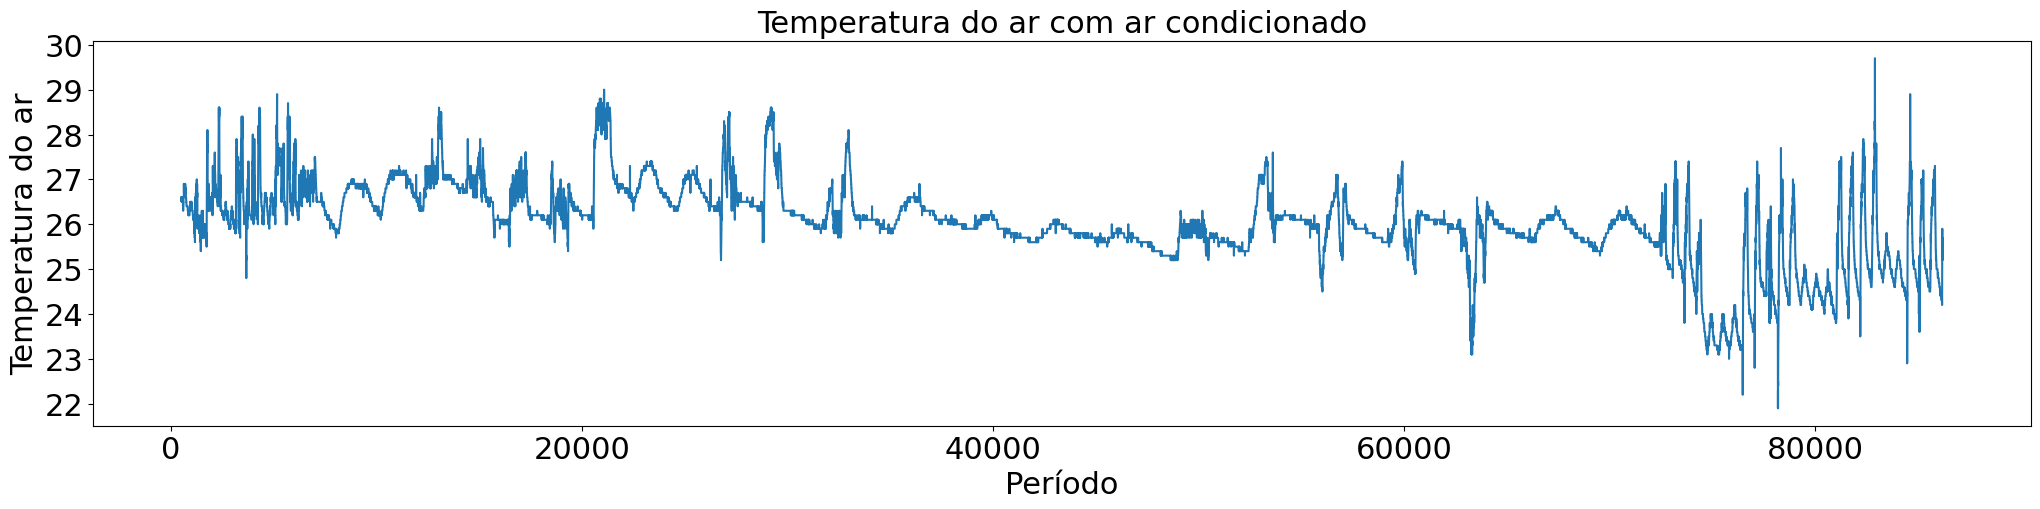

CPU times: user 419 ms, sys: 98 ms, total: 517 ms
Wall time: 408 ms


In [41]:
%%time
plt.figure(figsize=(25,5))
serie_comar.temp_ar.plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Período',size=22)
plt.ylabel('Temperatura do ar',size=22)
plt.title('Temperatura do ar com ar condicionado',size=22)

plt.savefig('data_temp_ar_conjunto_tratado_original.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

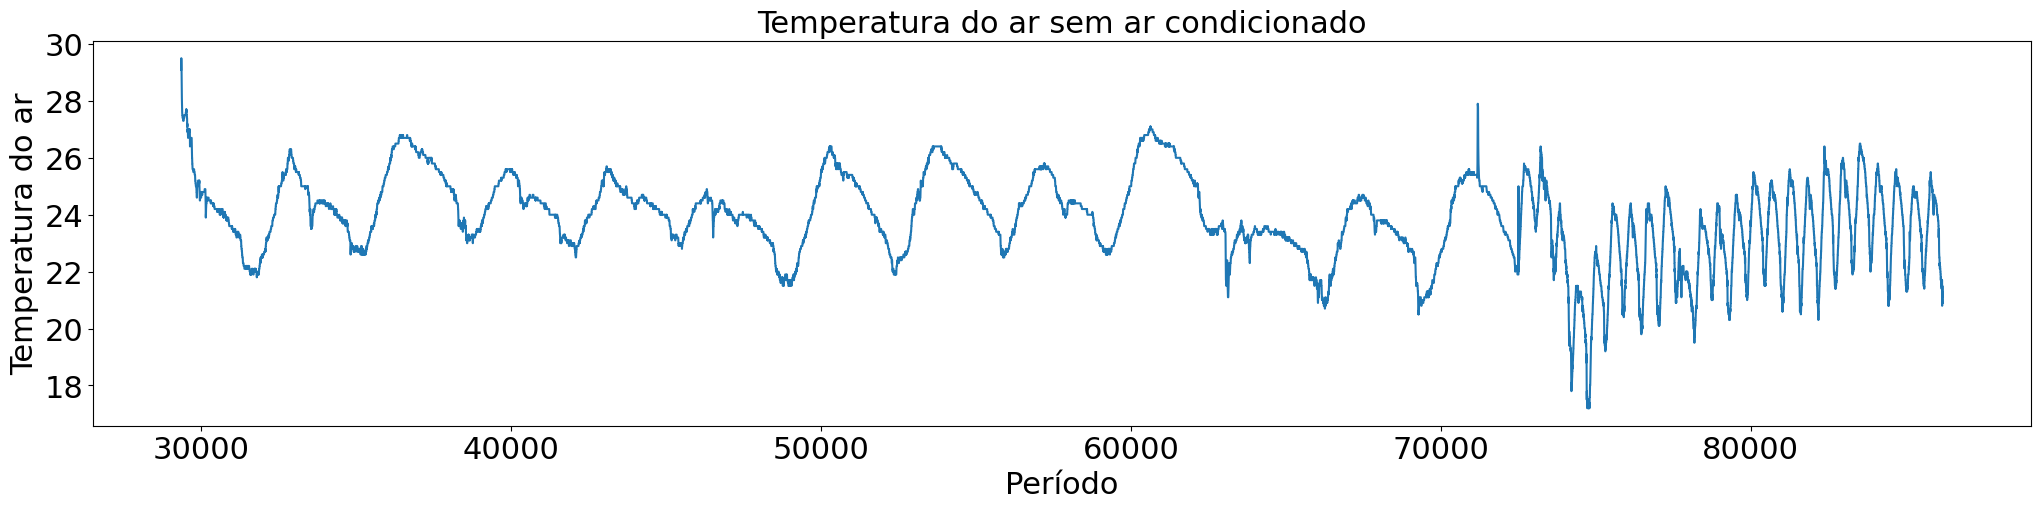

CPU times: user 381 ms, sys: 80.5 ms, total: 462 ms
Wall time: 390 ms


In [42]:
%%time
plt.figure(figsize=(25,5))
serie_semar.temp_ar.plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Período',size=22)
plt.ylabel('Temperatura do ar',size=22)
plt.title('Temperatura do ar sem ar condicionado',size=22)

plt.savefig('data_temp_ar_conjunto_tratado_original_sem_ar.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

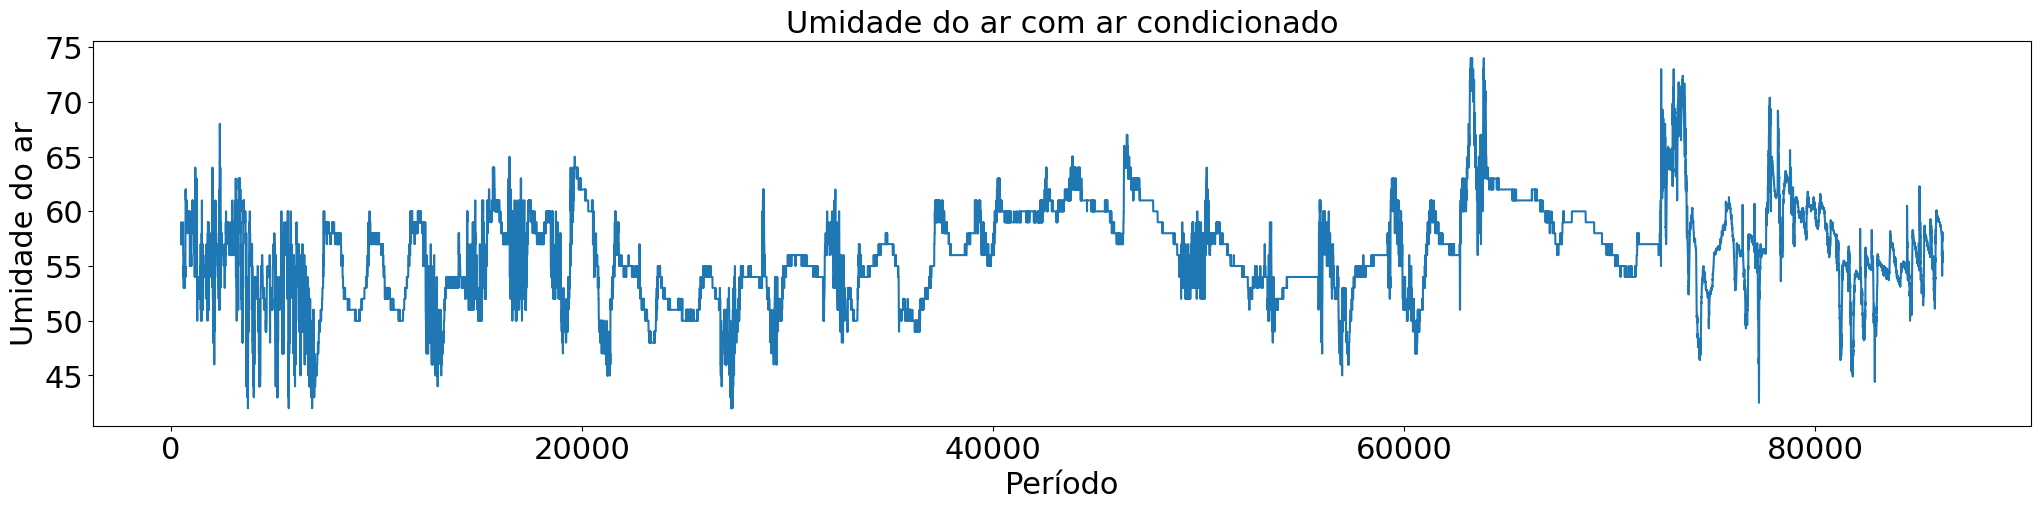

CPU times: user 403 ms, sys: 86.3 ms, total: 489 ms
Wall time: 413 ms


In [43]:
%%time
plt.figure(figsize=(25,5))
serie_comar.umid_ar.plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Período',size=22)
plt.ylabel('Umidade do ar',size=22)
plt.title('Umidade do ar com ar condicionado',size=22)

plt.savefig('data_umidade_ar_conjunto_tratado_original.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

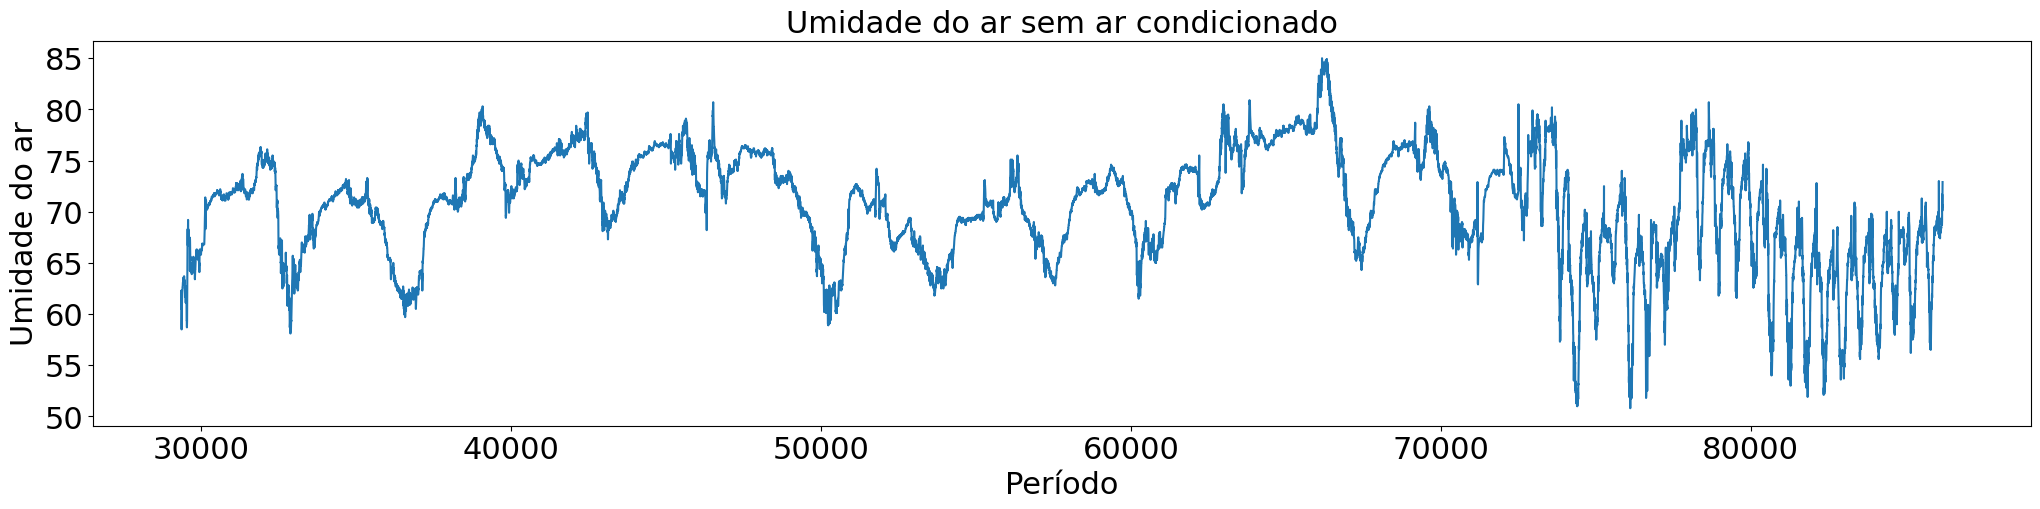

CPU times: user 426 ms, sys: 101 ms, total: 527 ms
Wall time: 415 ms


In [44]:
%%time
plt.figure(figsize=(25,5))
serie_semar.umid_ar.plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Período',size=22)
plt.ylabel('Umidade do ar',size=22)
plt.title('Umidade do ar sem ar condicionado',size=22)

plt.savefig('data_umidade_ar_conjunto_tratado_original_sem_ar.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

# Agrupando dados a cada t minuto(s) utilizando a média

Vamos tentar reduzir o ruído.

Definindo os minutos

In [45]:
minutos = 60

Setando a data como index

In [46]:
serie_comar.set_index('data', inplace=True)
serie_semar.set_index('data', inplace=True)

In [47]:
serie_comar.head(2)

,temp_ar,umid_ar
data,,
2023-03-04 00:04:12,26.60,57.00
2023-03-04 00:09:14,26.60,58.00


Agrupando os valores de data para cada t minuto(s) pela média

In [48]:
%%time
dados_agrupados_minutos_comar = serie_comar.resample(str(minutos) + 'T').mean()
dados_agrupados_minutos_comar.head(2)

CPU times: user 6.99 ms, sys: 1.82 ms, total: 8.81 ms
Wall time: 16.7 ms


,temp_ar,umid_ar
data,,
2023-03-04 00:00:00,26.60,57.58
2023-03-04 01:00:00,26.59,57.82


In [49]:
%%time
dados_agrupados_minutos_semar = serie_semar.resample(str(minutos) + 'T').mean()
dados_agrupados_minutos_semar.head(2)

CPU times: user 2.33 ms, sys: 0 ns, total: 2.33 ms
Wall time: 2.33 ms


,temp_ar,umid_ar
data,,
2023-04-04 15:00:00,27.68,62.30
2023-04-04 16:00:00,27.14,64.92


Tamanho do conjunto gerado

In [50]:
dados_agrupados_minutos_comar.shape

(1642, 2)

In [51]:
dados_agrupados_minutos_semar.shape

(883, 2)

Verificando nulos

In [52]:
dados_agrupados_minutos_comar.isnull().sum()

temp_ar    5
umid_ar    5
dtype: int64

In [53]:
dados_agrupados_minutos_semar.isnull().sum()

temp_ar    0
umid_ar    0
dtype: int64

Preenchendo nulos com os valores anteriores

In [54]:
dados_agrupados_minutos_comar.fillna(method="ffill", inplace = True)

Verificando novamente os nulos

In [55]:
dados_agrupados_minutos_comar.isnull().sum()

temp_ar    0
umid_ar    0
dtype: int64

# Gráficos

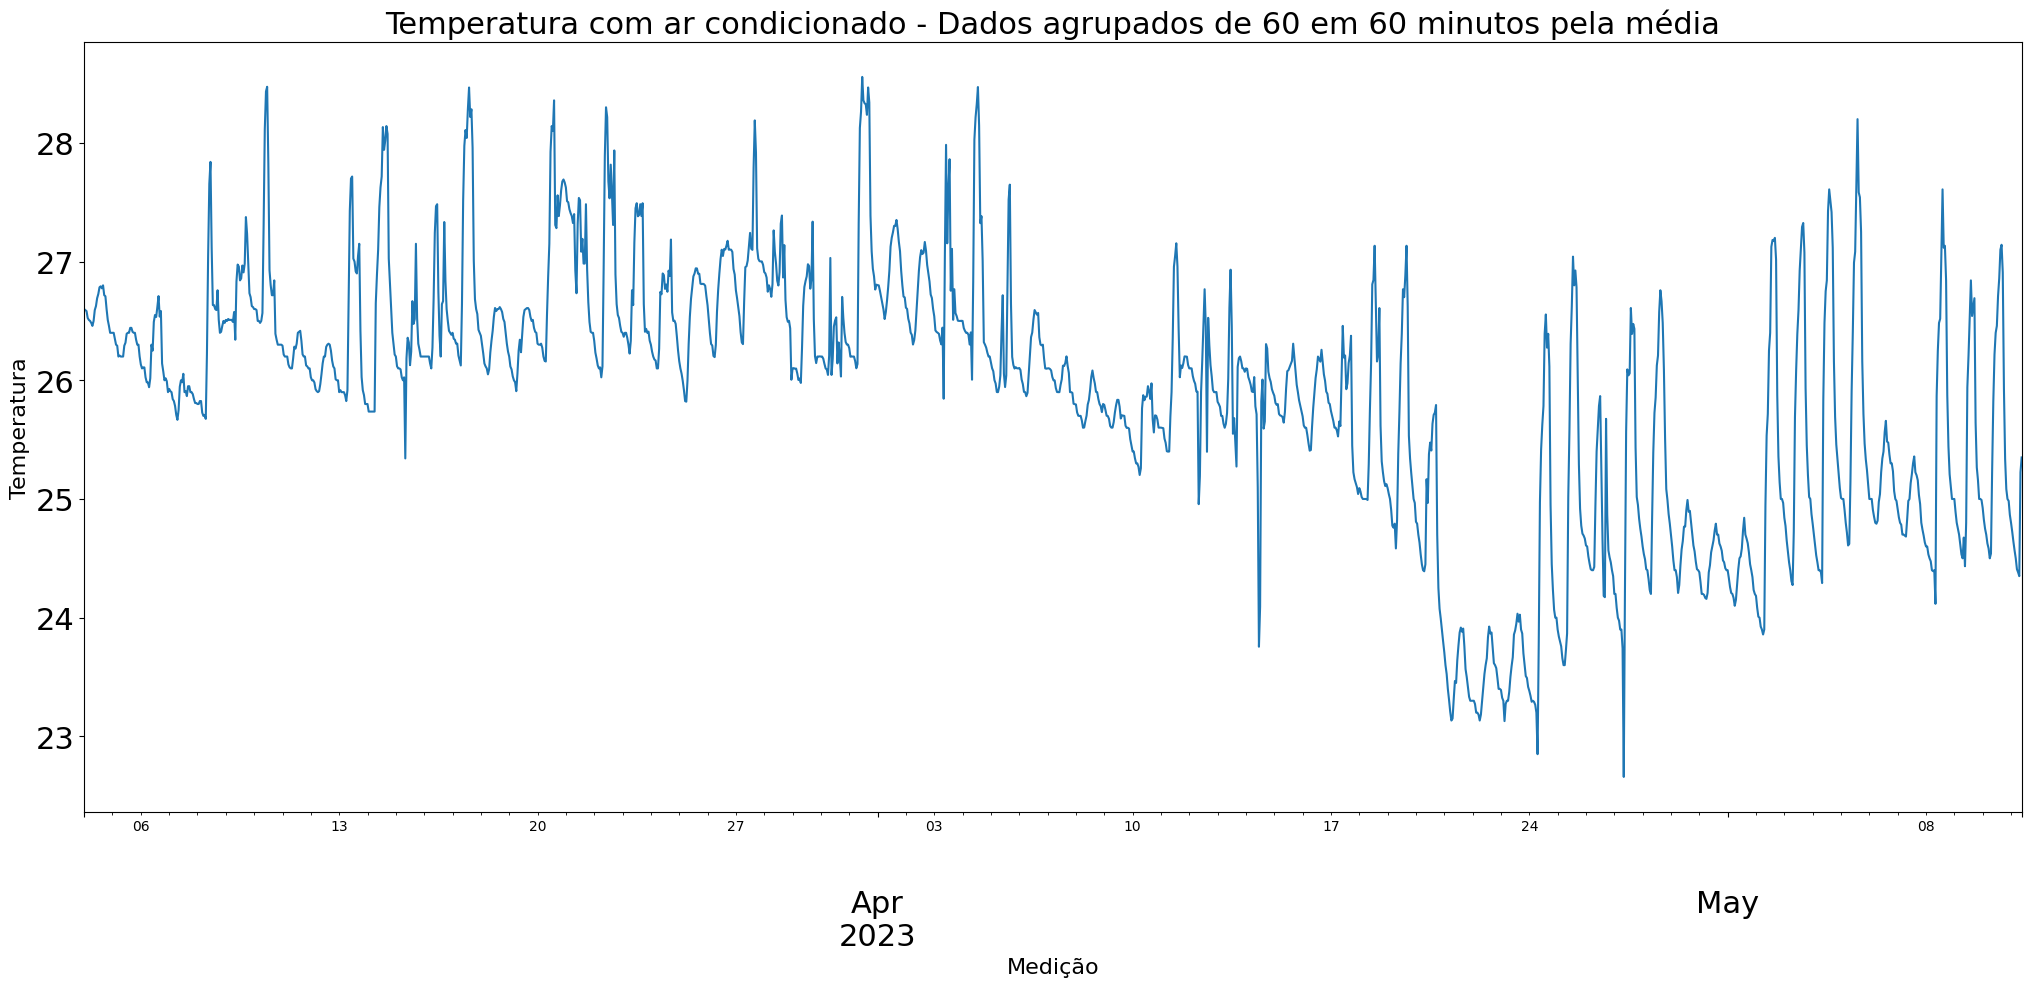

CPU times: user 724 ms, sys: 94.1 ms, total: 818 ms
Wall time: 740 ms


In [56]:
%%time
plt.figure(figsize=(25,10))
dados_agrupados_minutos_comar['temp_ar'].plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Medição',size=16)
plt.ylabel('Temperatura',size=16)
plt.title(f'Temperatura com ar condicionado - Dados agrupados de {minutos} em {minutos} minutos pela média',size=22)

plt.savefig(f'data_temperatura_ar_conjunto_dados_agrupados_{minutos}_minutos.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

plt.show()

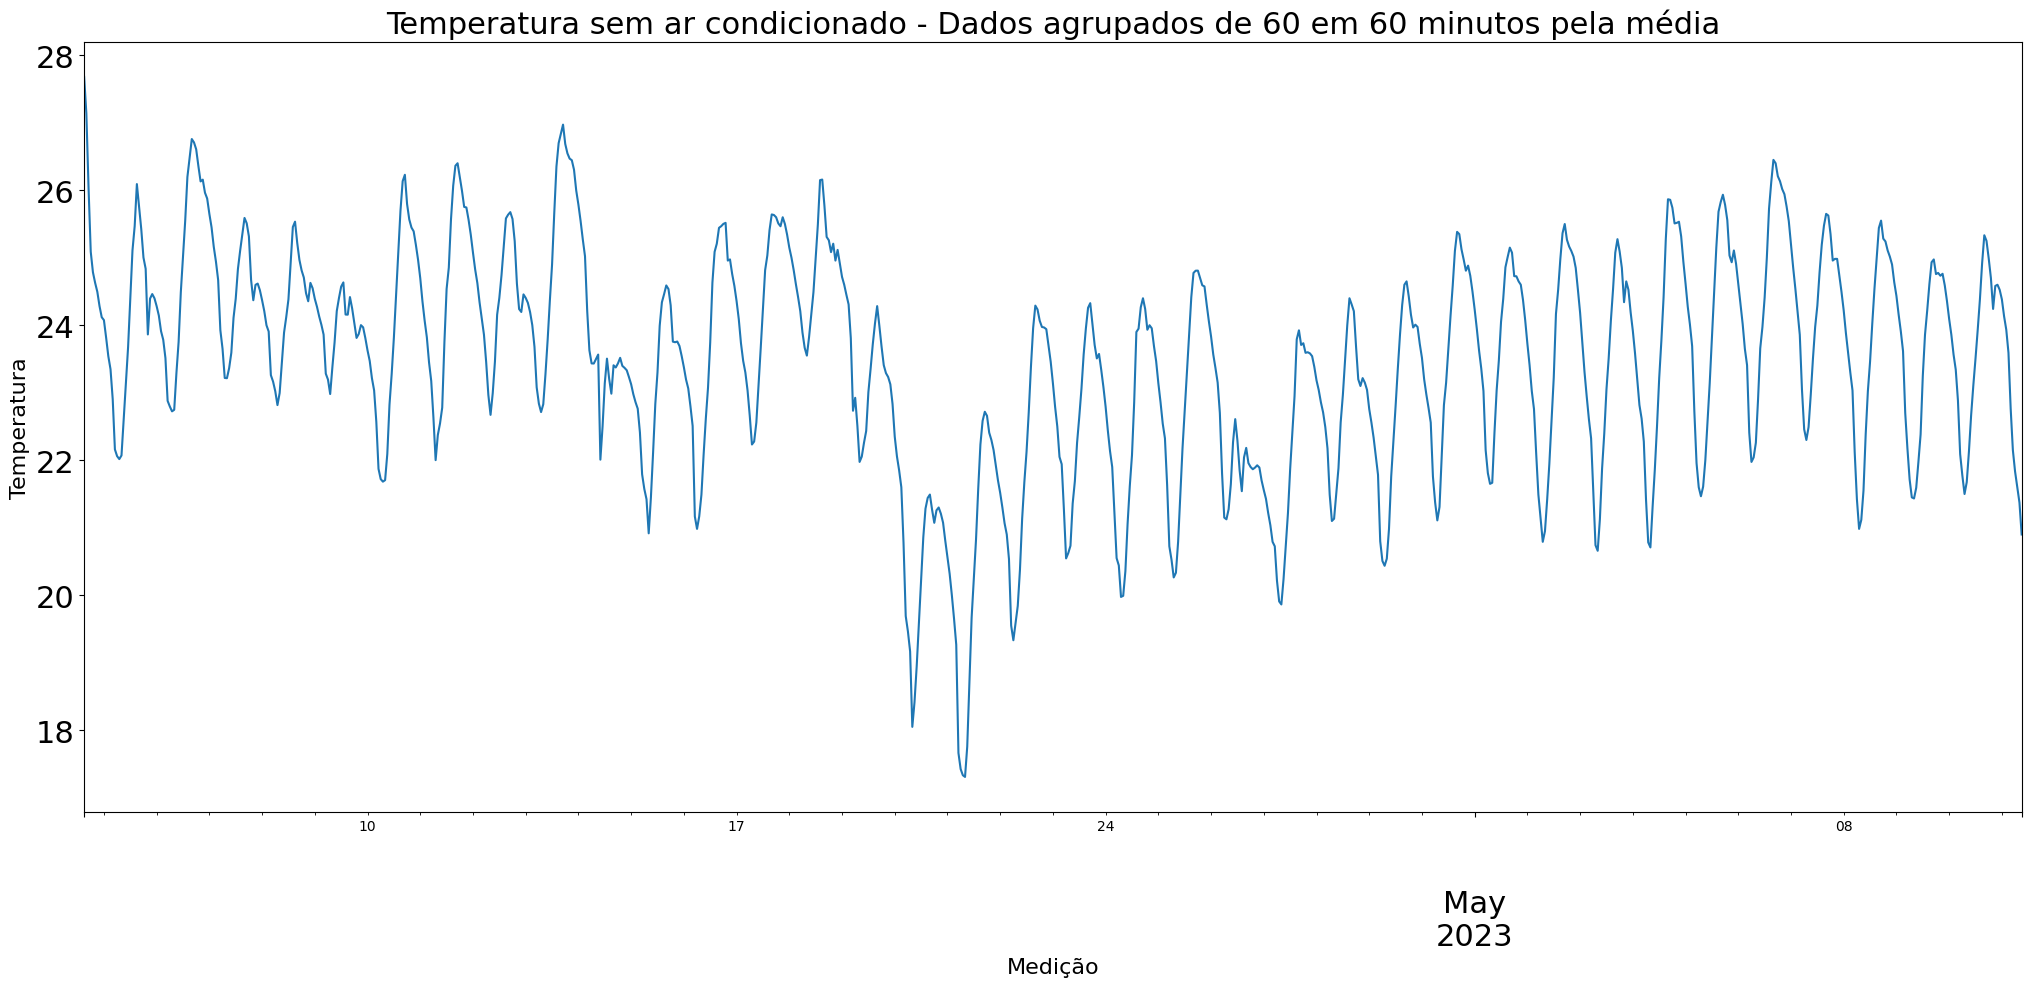

CPU times: user 609 ms, sys: 109 ms, total: 719 ms
Wall time: 609 ms


In [57]:
%%time
plt.figure(figsize=(25,10))
dados_agrupados_minutos_semar['temp_ar'].plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Medição',size=16)
plt.ylabel('Temperatura',size=16)
plt.title(f'Temperatura sem ar condicionado - Dados agrupados de {minutos} em {minutos} minutos pela média',size=22)

plt.savefig(f'data_temperatura_ar_conjunto_dados_agrupados_{minutos}_minutos_sem_ar.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

plt.show()

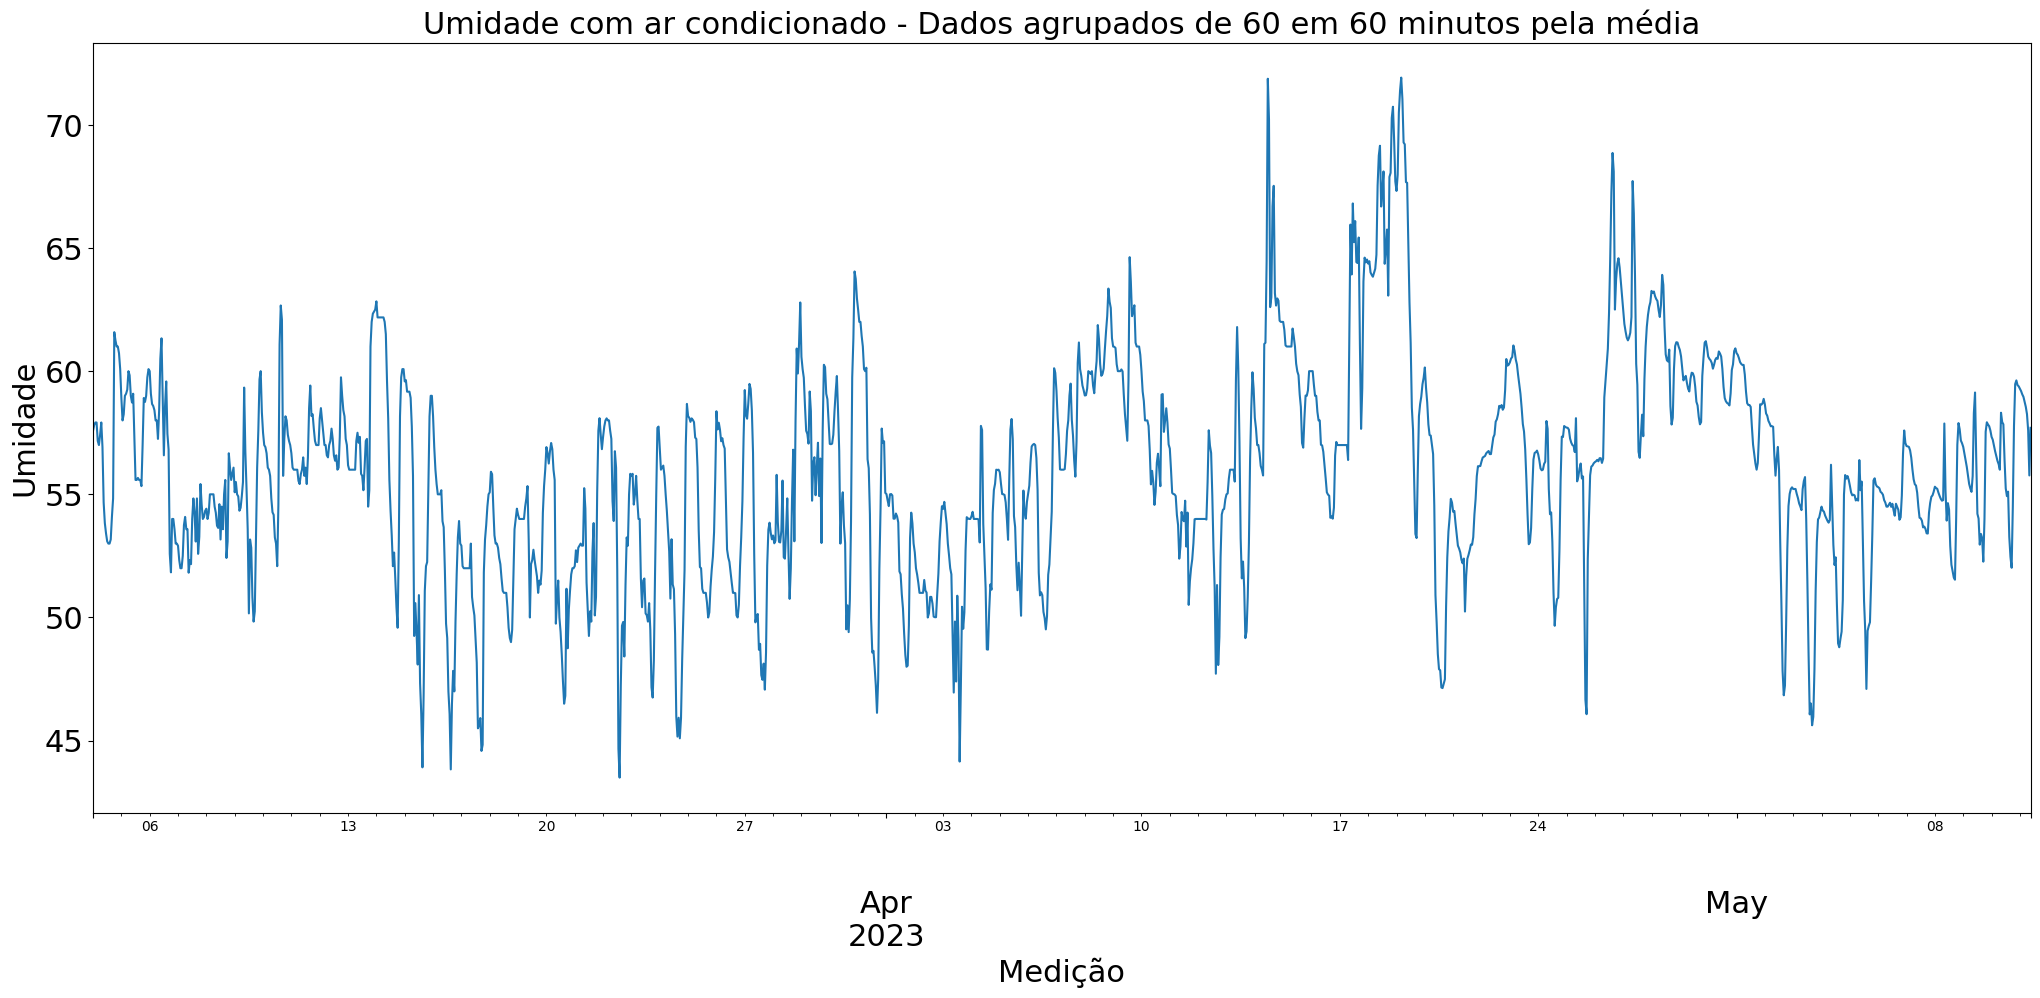

CPU times: user 772 ms, sys: 104 ms, total: 876 ms
Wall time: 766 ms


In [58]:
%%time
plt.figure(figsize=(25,10))
dados_agrupados_minutos_comar['umid_ar'].plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Medição',size=22)
plt.ylabel('Umidade',size=22)
plt.title(f'Umidade com ar condicionado - Dados agrupados de {minutos} em {minutos} minutos pela média',size=22)

plt.savefig(f'data_umidade_ar_conjunto_dados_agrupados_{minutos}_minutos.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

plt.show()

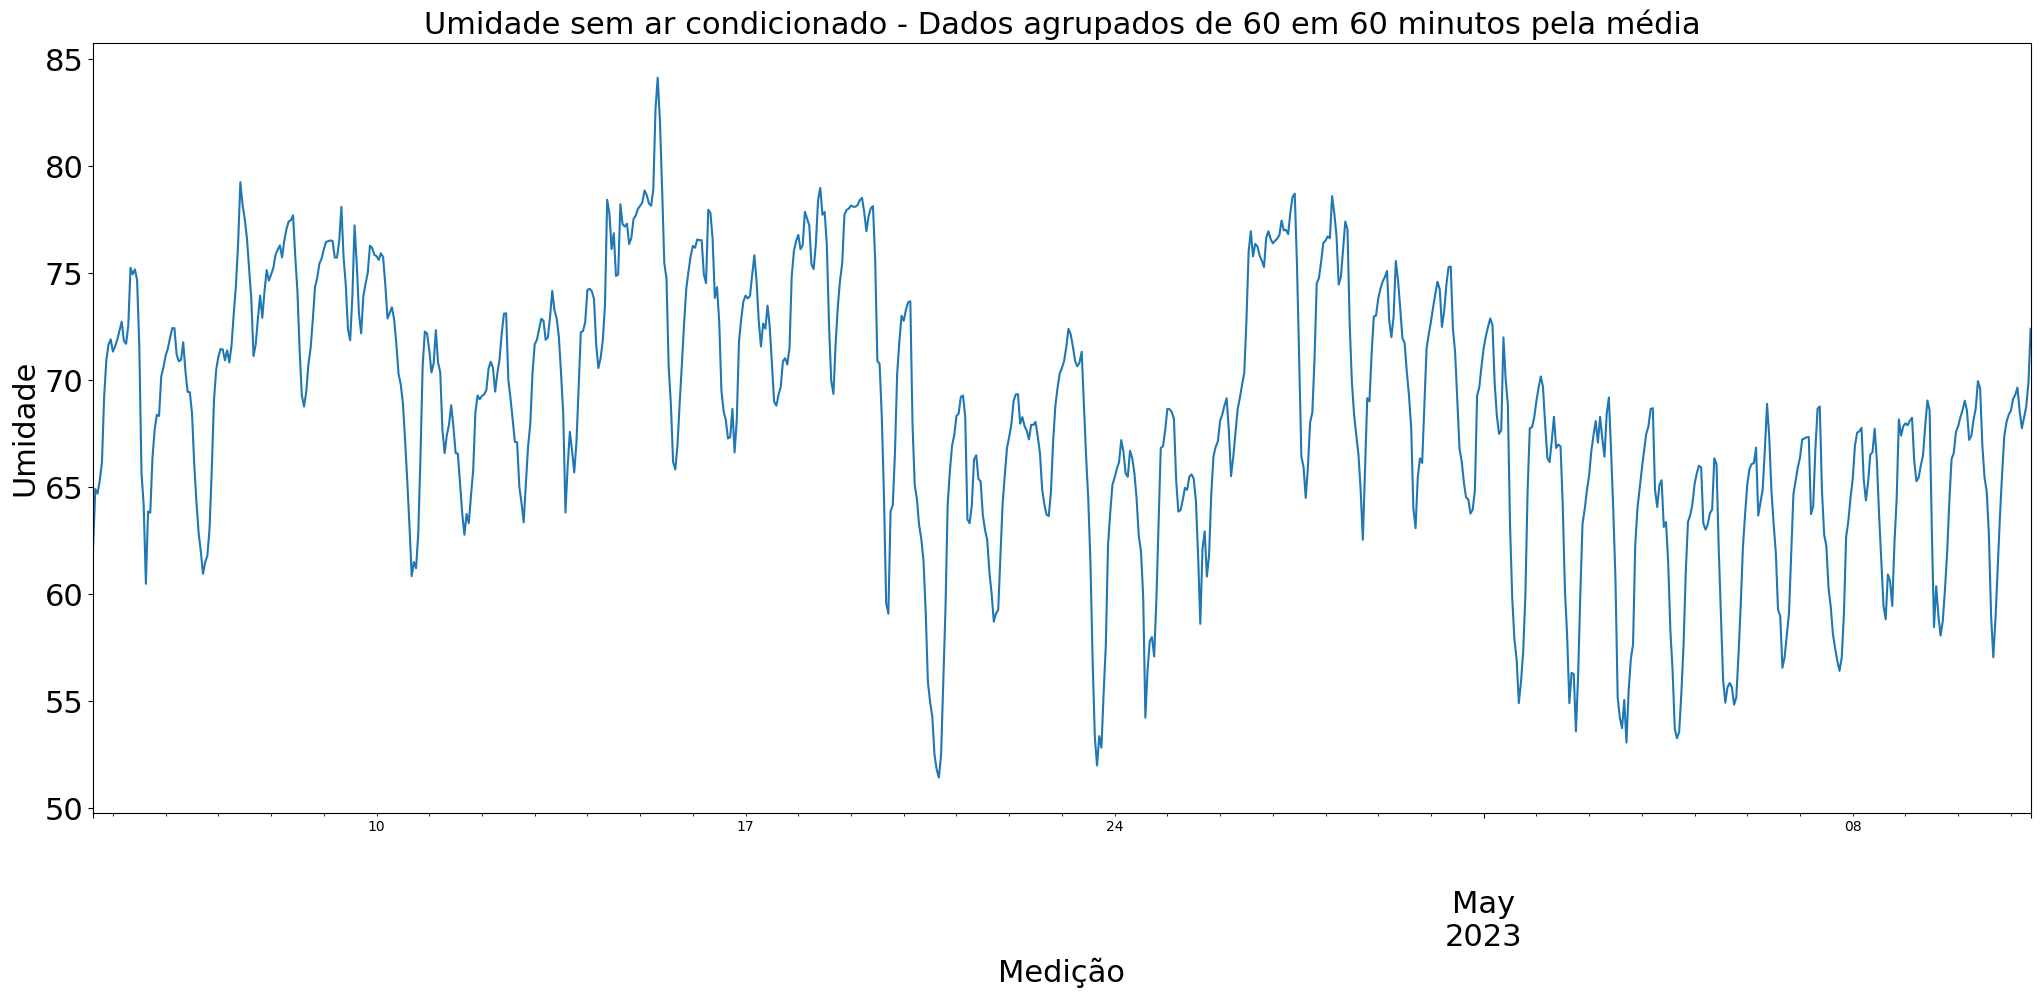

CPU times: user 659 ms, sys: 100 ms, total: 759 ms
Wall time: 655 ms


In [59]:
%%time
plt.figure(figsize=(25,10))
dados_agrupados_minutos_semar['umid_ar'].plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Medição',size=22)
plt.ylabel('Umidade',size=22)
plt.title(f'Umidade sem ar condicionado - Dados agrupados de {minutos} em {minutos} minutos pela média',size=22)

plt.savefig(f'data_umidade_ar_conjunto_dados_agrupados_{minutos}_minutos_sem_ar.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

plt.show()

# Suavização com média móvel e rolling

In [60]:
dados_agrupados_minutos_comar_cp = dados_agrupados_minutos_comar.copy()
dados_agrupados_minutos_semar_cp = dados_agrupados_minutos_semar.copy()

In [61]:
''' dados_agrupados_minutos_comar = dados_agrupados_minutos_comar_cp
dados_agrupados_minutos_semar = dados_agrupados_minutos_semar_cp '''

' dados_agrupados_minutos_comar = dados_agrupados_minutos_comar_cp\ndados_agrupados_minutos_semar = dados_agrupados_minutos_semar_cp '

In [62]:
dados_agrupados_minutos_comar['media_24_horas_temp_ar'] = dados_agrupados_minutos_comar.temp_ar.rolling(48).mean()
dados_agrupados_minutos_comar['media_24_horas_umid_ar'] = dados_agrupados_minutos_comar.umid_ar.rolling(48).mean()

dados_agrupados_minutos_semar['media_24_horas_temp_ar'] = dados_agrupados_minutos_semar.temp_ar.rolling(48).mean()
dados_agrupados_minutos_semar['media_24_horas_umid_ar'] = dados_agrupados_minutos_semar.umid_ar.rolling(48).mean()

In [63]:
dados_agrupados_minutos_comar.head(24)

,temp_ar,umid_ar,media_24_horas_temp_ar,media_24_horas_umid_ar
data,,,,
2023-03-04 00:00:00,26.60,57.58,NaN,NaN
2023-03-04 01:00:00,26.59,57.82,NaN,NaN
2023-03-04 02:00:00,26.58,57.92,NaN,NaN
2023-03-04 03:00:00,26.53,57.92,NaN,NaN
2023-03-04 04:00:00,26.51,57.17,NaN,NaN
2023-03-04 05:00:00,26.50,57.00,NaN,NaN
2023-03-04 06:00:00,26.48,57.42,NaN,NaN
2023-03-04 07:00:00,26.46,57.92,NaN,NaN
2023-03-04 08:00:00,26.50,56.92,NaN,NaN


Comparando a média móvel com os dados

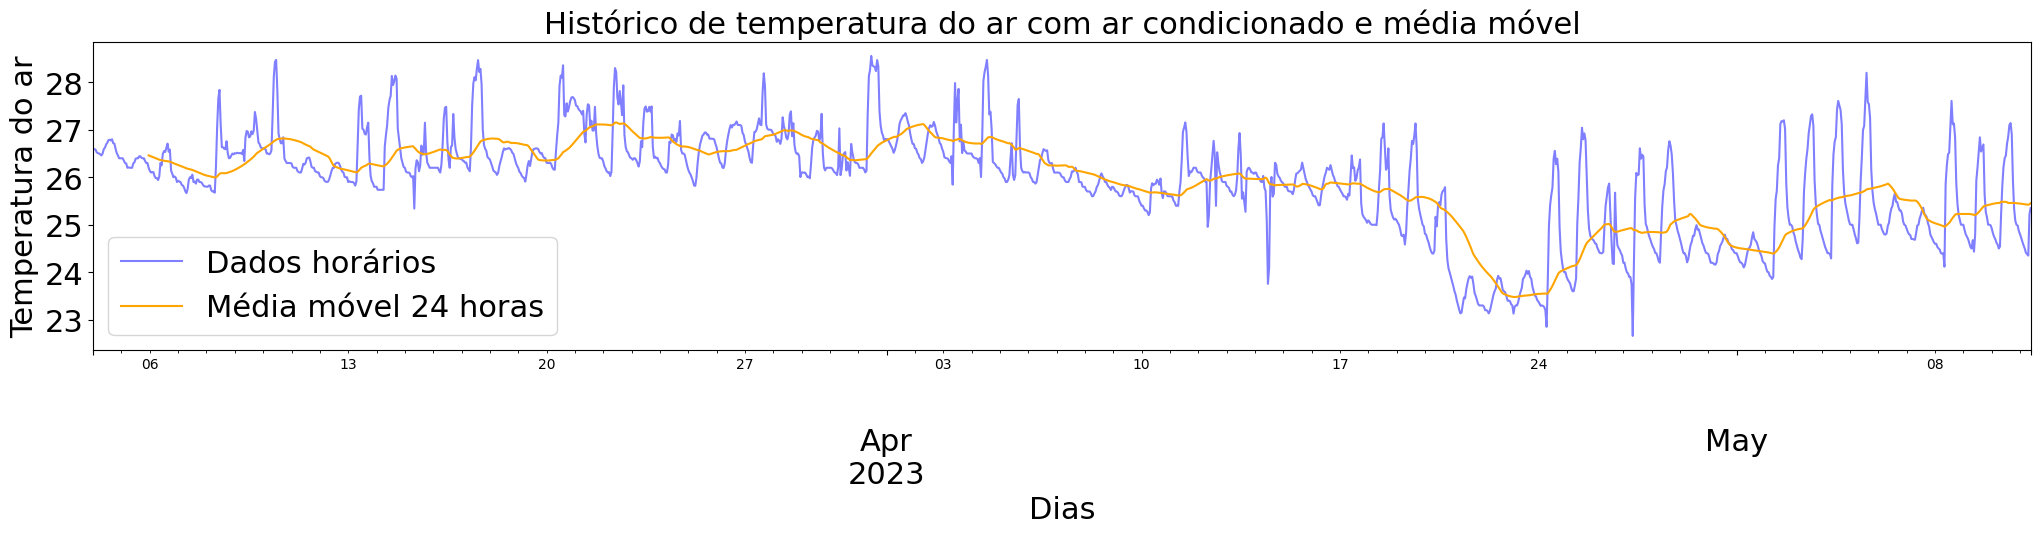

CPU times: user 1.13 s, sys: 56 ms, total: 1.18 s
Wall time: 1.23 s


In [64]:
%%time
plt.figure(figsize=(25,4))
dados_agrupados_minutos_comar.temp_ar.plot(c='blue',alpha=0.5) # Dados reais
dados_agrupados_minutos_comar['media_24_horas_temp_ar'].plot(c='orange') # Dados da média móvel
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dias',size=22)
plt.ylabel('Temperatura do ar',size=22)
plt.title('Histórico de temperatura do ar com ar condicionado e média móvel',size=22)
plt.legend(['Dados horários','Média móvel 24 horas'],fontsize=22)

plt.savefig(f'data_temperatura_ar_comar_conjunto_dados_agrupados_{minutos}_minutos_com_media_movel.png', facecolor='white', transparent=False)
plt.show()

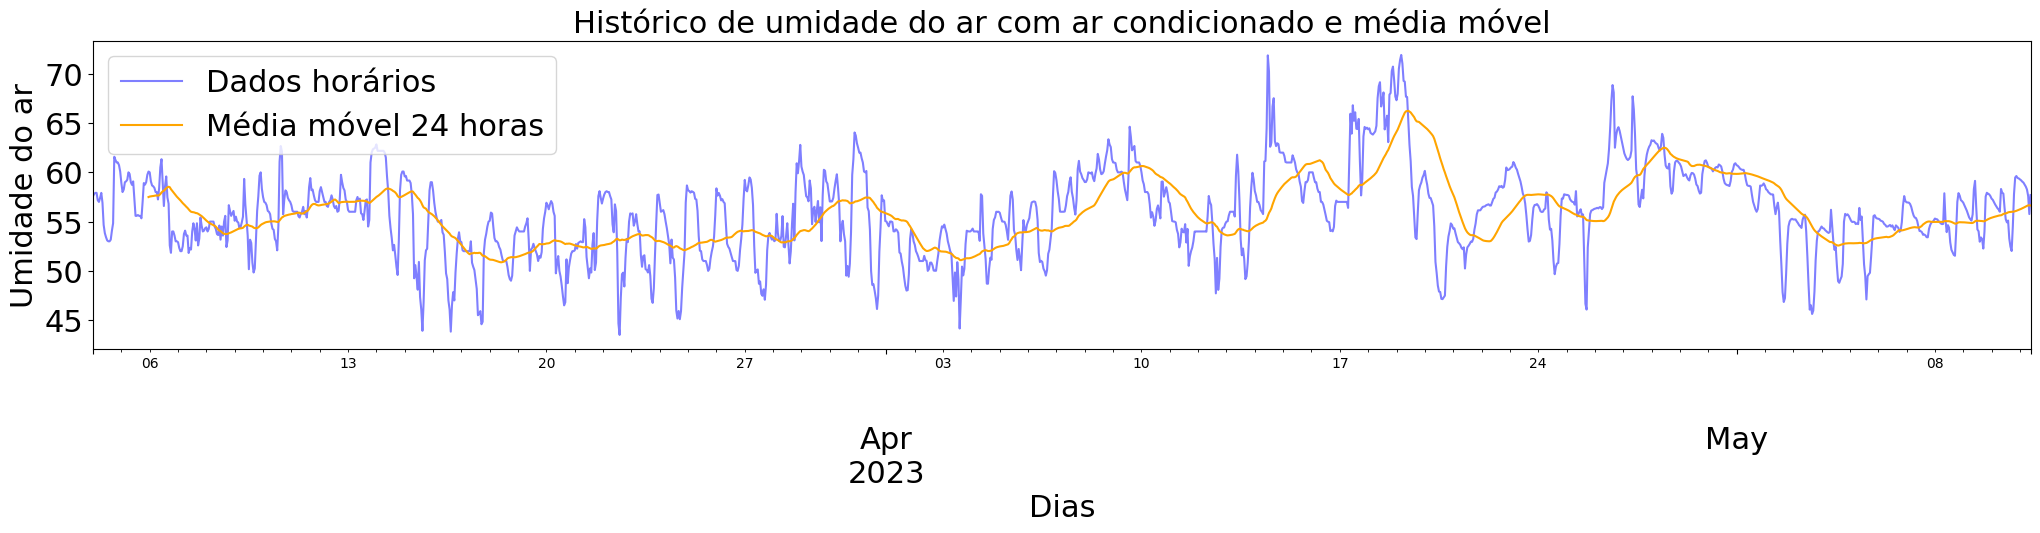

CPU times: user 701 ms, sys: 45.1 ms, total: 746 ms
Wall time: 772 ms


In [65]:
%%time
plt.figure(figsize=(25,4))
dados_agrupados_minutos_comar.umid_ar.plot(c='blue',alpha=0.5) # Dados reais
dados_agrupados_minutos_comar['media_24_horas_umid_ar'].plot(c='orange') # Dados da média móvel
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dias',size=22)
plt.ylabel('Umidade do ar',size=22)
plt.title('Histórico de umidade do ar com ar condicionado e média móvel',size=22)
plt.legend(['Dados horários','Média móvel 24 horas'],fontsize=22)
plt.show()

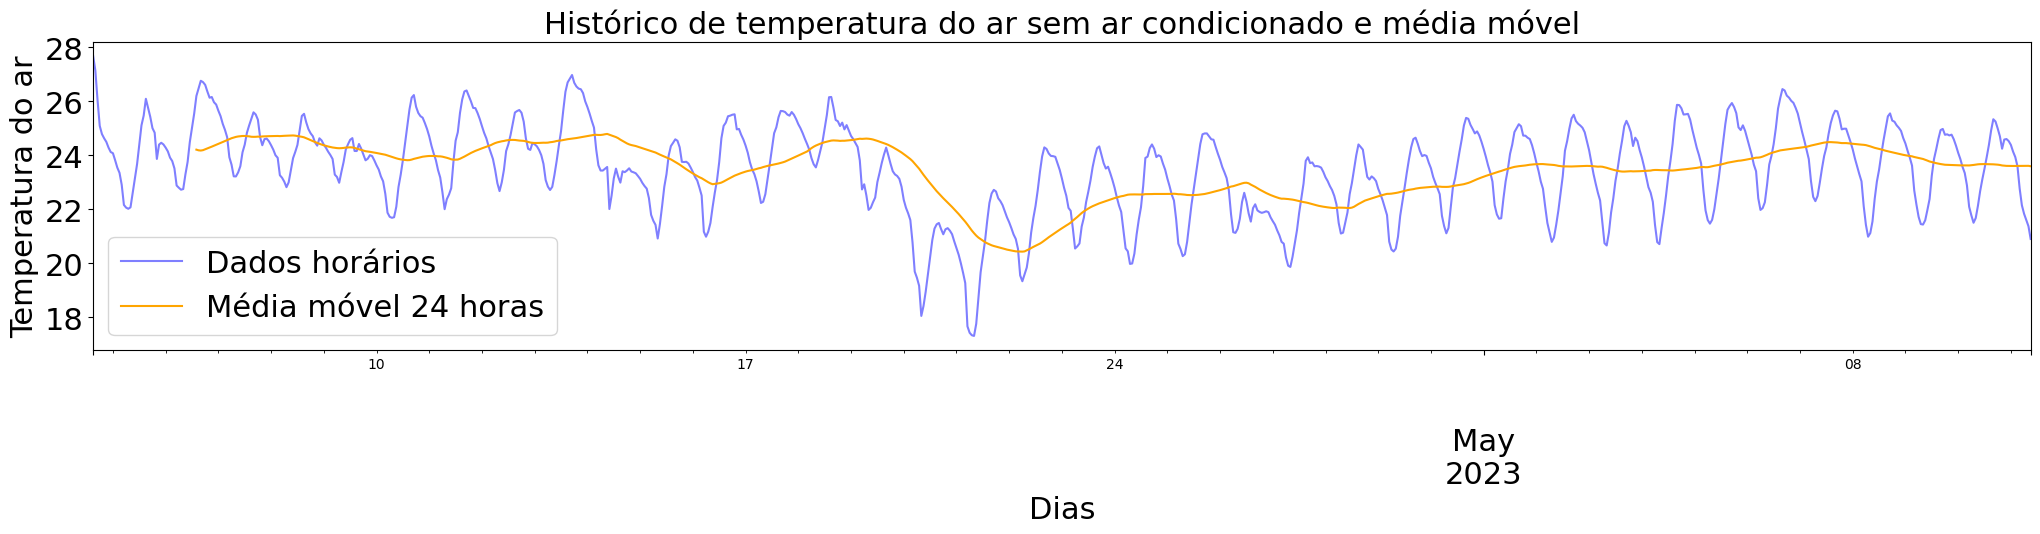

CPU times: user 565 ms, sys: 110 ms, total: 675 ms
Wall time: 561 ms


In [66]:
%%time
plt.figure(figsize=(25,4))
dados_agrupados_minutos_semar.temp_ar.plot(c='blue',alpha=0.5) # Dados reais
dados_agrupados_minutos_semar['media_24_horas_temp_ar'].plot(c='orange') # Dados da média móvel
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dias',size=22)
plt.ylabel('Temperatura do ar',size=22)
plt.title('Histórico de temperatura do ar sem ar condicionado e média móvel',size=22)
plt.legend(['Dados horários','Média móvel 24 horas'],fontsize=22)

plt.savefig(f'data_temperatura_ar_semar_conjunto_dados_agrupados_{minutos}_minutos_com_media_movel.png', facecolor='white', transparent=False)
plt.show()

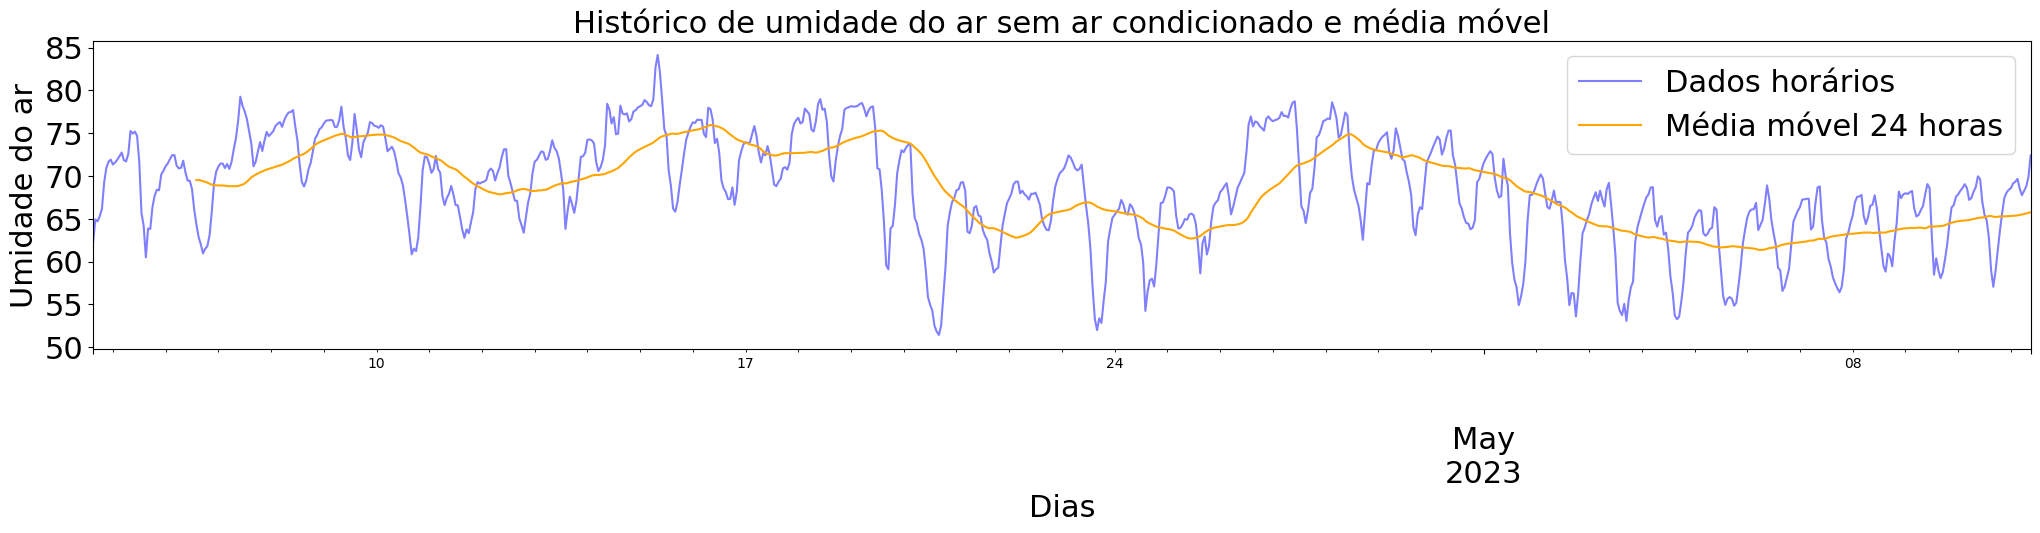

CPU times: user 408 ms, sys: 108 ms, total: 515 ms
Wall time: 397 ms


In [67]:
%%time
plt.figure(figsize=(25,4))
dados_agrupados_minutos_semar.umid_ar.plot(c='blue',alpha=0.5) # Dados reais
dados_agrupados_minutos_semar['media_24_horas_umid_ar'].plot(c='orange') # Dados da média móvel
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dias',size=22)
plt.ylabel('Umidade do ar',size=22)
plt.title('Histórico de umidade do ar sem ar condicionado e média móvel',size=22)
plt.legend(['Dados horários','Média móvel 24 horas'],fontsize=22)
plt.show()

# ARIMA


In [68]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 51.0 MB/s eta 0:00:00


In [69]:
%%time
from pmdarima.arima import auto_arima
modelo = auto_arima(dados_agrupados_minutos_comar.temp_ar)

CPU times: user 32.9 s, sys: 25.2 s, total: 58.1 s
Wall time: 41.8 s


In [70]:
modelo.predict_in_sample()

data
2023-03-04 00:00:00    0.00
2023-03-04 01:00:00   26.60
2023-03-04 02:00:00   26.59
2023-03-04 03:00:00   26.58
2023-03-04 04:00:00   26.51
                       ... 
2023-05-11 05:00:00   24.58
2023-05-11 06:00:00   24.49
2023-05-11 07:00:00   24.49
2023-05-11 08:00:00   24.45
2023-05-11 09:00:00   25.54
Freq: 60T, Name: predicted_mean, Length: 1642, dtype: float64

In [71]:
modelo.predict(12)

2023-05-11 10:00:00   25.40
2023-05-11 11:00:00   25.56
2023-05-11 12:00:00   25.60
2023-05-11 13:00:00   25.59
2023-05-11 14:00:00   25.57
2023-05-11 15:00:00   25.54
2023-05-11 16:00:00   25.50
2023-05-11 17:00:00   25.46
2023-05-11 18:00:00   25.43
2023-05-11 19:00:00   25.40
2023-05-11 20:00:00   25.37
2023-05-11 21:00:00   25.35
Freq: 60T, dtype: float64

In [72]:
%%time
modelo_semar = auto_arima(dados_agrupados_minutos_semar.temp_ar)

CPU times: user 3.7 s, sys: 2.87 s, total: 6.57 s
Wall time: 4.66 s


In [73]:
modelo_semar.predict_in_sample()

data
2023-04-04 15:00:00    0.00
2023-04-04 16:00:00   27.68
2023-04-04 17:00:00   26.75
2023-04-04 18:00:00   25.25
2023-04-04 19:00:00   24.41
                       ... 
2023-05-11 05:00:00   22.18
2023-05-11 06:00:00   21.71
2023-05-11 07:00:00   21.61
2023-05-11 08:00:00   21.45
2023-05-11 09:00:00   21.20
Freq: 60T, Name: predicted_mean, Length: 883, dtype: float64

In [74]:
modelo_semar.predict(12)

2023-05-11 10:00:00   20.56
2023-05-11 11:00:00   20.32
2023-05-11 12:00:00   20.15
2023-05-11 13:00:00   20.02
2023-05-11 14:00:00   19.94
2023-05-11 15:00:00   19.87
2023-05-11 16:00:00   19.83
2023-05-11 17:00:00   19.79
2023-05-11 18:00:00   19.77
2023-05-11 19:00:00   19.76
2023-05-11 20:00:00   19.74
2023-05-11 21:00:00   19.73
Freq: 60T, dtype: float64

## Salvando o modelo com ar condicionado

In [75]:
with open('model_comar','wb') as f:
        pickle.dump(modelo,f)

In [76]:
ultimas_horas_com_ar = dados_agrupados_minutos_comar.temp_ar.tail(20)
index_str = ultimas_horas_com_ar.index.astype('str')
ultimas_horas_com_ar = ultimas_horas_com_ar.reindex(index_str).to_dict()
ultimas_horas_com_ar

pickle.dump(ultimas_horas_com_ar, open('ultimas_horas_com_ar.p', 'wb'))

In [77]:
with open('model_comar','rb') as f:
        modelo_salvo_comar = pickle.load(f)

In [89]:
with open('ultimas_horas_com_ar.p', 'rb') as f:
  ultimas_horas_com_ar_d = pickle.load(f)
ultimas_horas_com_ar_d

{'2023-05-10 14:00:00': 26.858333333333334,
 '2023-05-10 15:00:00': 27.099999999999998,
 '2023-05-10 16:00:00': 27.141666666666666,
 '2023-05-10 17:00:00': 26.90909090909091,
 '2023-05-10 18:00:00': 25.925,
 '2023-05-10 19:00:00': 25.336363636363636,
 '2023-05-10 20:00:00': 25.083333333333332,
 '2023-05-10 21:00:00': 25.0,
 '2023-05-10 22:00:00': 24.983333333333334,
 '2023-05-10 23:00:00': 24.866666666666664,
 '2023-05-11 00:00:00': 24.8,
 '2023-05-11 01:00:00': 24.724999999999998,
 '2023-05-11 02:00:00': 24.641666666666666,
 '2023-05-11 03:00:00': 24.566666666666666,
 '2023-05-11 04:00:00': 24.5,
 '2023-05-11 05:00:00': 24.40833333333333,
 '2023-05-11 06:00:00': 24.38181818181818,
 '2023-05-11 07:00:00': 24.349999999999998,
 '2023-05-11 08:00:00': 25.224999999999998,
 '2023-05-11 09:00:00': 25.35}

In [79]:
modelo_salvo_comar.predict(12)

2023-05-11 10:00:00   25.40
2023-05-11 11:00:00   25.56
2023-05-11 12:00:00   25.60
2023-05-11 13:00:00   25.59
2023-05-11 14:00:00   25.57
2023-05-11 15:00:00   25.54
2023-05-11 16:00:00   25.50
2023-05-11 17:00:00   25.46
2023-05-11 18:00:00   25.43
2023-05-11 19:00:00   25.40
2023-05-11 20:00:00   25.37
2023-05-11 21:00:00   25.35
Freq: 60T, dtype: float64

## Salvando o modelo sem ar condicionado

In [80]:
with open('model_semar','wb') as f:
        pickle.dump(modelo_semar,f)

In [81]:
with open('model_semar','rb') as f:
        modelo_salvo_semar = pickle.load(f)

In [87]:
ultimas_horas_sem_ar = dados_agrupados_minutos_semar.temp_ar.tail(20)
index_str = ultimas_horas_sem_ar.index.astype('str')
ultimas_horas_sem_ar = ultimas_horas_sem_ar.reindex(index_str).to_dict()

pickle.dump(ultimas_horas_sem_ar, open('ultimas_horas_sem_ar.p', 'wb'))

In [88]:
with open('ultimas_horas_sem_ar.p', 'rb') as f:
  ultimas_horas_sem_ar_d = pickle.load(f)
ultimas_horas_sem_ar_d


{'2023-05-10 14:00:00': 24.383333333333336,
 '2023-05-10 15:00:00': 24.916666666666668,
 '2023-05-10 16:00:00': 25.333333333333332,
 '2023-05-10 17:00:00': 25.25,
 '2023-05-10 18:00:00': 24.991666666666664,
 '2023-05-10 19:00:00': 24.7,
 '2023-05-10 20:00:00': 24.241666666666664,
 '2023-05-10 21:00:00': 24.58181818181818,
 '2023-05-10 22:00:00': 24.600000000000005,
 '2023-05-10 23:00:00': 24.525000000000002,
 '2023-05-11 00:00:00': 24.38333333333333,
 '2023-05-11 01:00:00': 24.133333333333336,
 '2023-05-11 02:00:00': 23.933333333333334,
 '2023-05-11 03:00:00': 23.59166666666667,
 '2023-05-11 04:00:00': 22.766666666666666,
 '2023-05-11 05:00:00': 22.150000000000002,
 '2023-05-11 06:00:00': 21.833333333333332,
 '2023-05-11 07:00:00': 21.608333333333334,
 '2023-05-11 08:00:00': 21.37272727272727,
 '2023-05-11 09:00:00': 20.9}

In [82]:
modelo_salvo_semar.predict(12)

2023-05-11 10:00:00   20.56
2023-05-11 11:00:00   20.32
2023-05-11 12:00:00   20.15
2023-05-11 13:00:00   20.02
2023-05-11 14:00:00   19.94
2023-05-11 15:00:00   19.87
2023-05-11 16:00:00   19.83
2023-05-11 17:00:00   19.79
2023-05-11 18:00:00   19.77
2023-05-11 19:00:00   19.76
2023-05-11 20:00:00   19.74
2023-05-11 21:00:00   19.73
Freq: 60T, dtype: float64